# Stereoscope application to 10X left ventricule public data.

- Developed by Carlos Talavera-López Ph.D, WSI, edited by Romain Lopez
- Version: 210108

In this notebook, we present the workflow to run Stereoscope within the scvi-tools codebase. 

In [1]:
import sys

#if True, will install via pypi, else will install from source
stable = False
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 61kB 5.5MB/s 
ERROR: nbclient 0.5.1 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 122kB 8.3MB/s 
     |████████████████████████████████| 686kB 14.3MB/s 
     |████████████████████████████████| 245kB 17.6MB/s 
     |████████████████████████████████| 194kB 27.9MB/s 
     |████████████████████████████████| 8.7MB 10.2MB/s 
     |████████████████████████████████| 2.4MB 55.2MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 3.2MB 44.2MB/s 
     |████████████████████████████████| 10.2MB 44.6MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 645kB 61.2MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |█████████████████████████

In [2]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from scvi.data import register_tensor_from_anndata
from scvi.external.stereoscope import RNAStereoscope, SpatialStereoscope

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Download and preprocess data

In [3]:
!wget -O hca_heart_LV_stereoscope_subset_raw_ctl201217.h5ad https://ndownloader.figshare.com/files/26153564
# !wget -O 10x_lv.tar.xz https://ndownloader.figshare.com/files/26153591
# !mkdir 10x_lv
# !tar -xf 10x_lv.tar.xz -C 10x_lv/

--2021-01-22 22:34:06--  https://ndownloader.figshare.com/files/26153564
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.49.95.77, 52.213.45.223, 34.247.222.121, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.49.95.77|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/26153564/hca_heart_LV_stereoscope_subset_raw_ctl201217.h5ad [following]
--2021-01-22 22:34:07--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/26153564/hca_heart_LV_stereoscope_subset_raw_ctl201217.h5ad
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.110.59
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.110.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130445704 (124M) [application/octet-stream]
Saving to: ‘hca_heart_LV_stereoscope_subset_raw_ctl201217.h5ad’

hca_heart_LV_stereo 100%[===================

## Read in single-cell data

Read in expression data. This is a subset of the data you want to map. Here I use a balanced subset of cells from the left ventricle (~ 50K). You can create your own subset according to what you are interested in. 

In [4]:
sc_adata = sc.read_h5ad("/content/hca_heart_LV_stereoscope_subset_raw_ctl201217.h5ad")
sc_adata

AnnData object with n_obs × n_vars = 35928 × 33538
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

In [5]:
sc.pp.filter_genes(sc_adata, min_counts = 10)
sc_adata

AnnData object with n_obs × n_vars = 35928 × 25145
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

In [6]:
sc_adata.obs['combined'] = [sc_adata.obs.loc[i,'cell_source'] + sc_adata.obs.loc[i,'donor'] for i in sc_adata.obs_names]
sc_adata

AnnData object with n_obs × n_vars = 35928 × 25145
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

Remove mitochondrial genes

In [7]:
non_mito_genes_list = [name for name in sc_adata.var_names if not name.startswith('MT-')]
sc_adata = sc_adata[:, non_mito_genes_list]
sc_adata

View of AnnData object with n_obs × n_vars = 35928 × 25132
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

Normalize data to filter genes (Stereoscope works will raw counts). We did not see better results by using all the genes, so for computational purposed we cut here to 7,000 genes.

In [8]:
sc_adata.layers["counts"] = sc_adata.X.copy()
sc.pp.normalize_total(sc_adata, target_sum = 10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

In [9]:
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes = 7000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key = 'combined',
    span = 1
)

Examine the cell type labels

In [10]:
sc_adata.obs["cell_states"].value_counts()

FB1            2000
vCM3           2000
vCM2           2000
vCM1           2000
vCM4           2000
SMC1_basic     2000
PC3_str        2000
PC1_vent       2000
EC5_art        2000
EC1_cap        2000
EC2_cap        2000
FB4            1912
EC3_cap        1712
EC6_ven        1292
DOCK4+MØ1       970
EC4_immune      751
CD4+T_cytox     642
NC1             524
Mast            453
FB3             436
CD8+T_cytox     429
LYVE1+MØ1       394
LYVE1+MØ2       390
CD8+T_tem       368
SMC2_art        323
NK              322
FB2             308
FB5             245
vCM5            235
CD16+Mo         234
Mo_pi           227
NKT             224
LYVE1+MØ3       223
CD4+T_tem       170
DC              143
CD14+Mo         132
Adip1           126
MØ_AgP          116
B_cells         112
NC2             102
DOCK4+MØ2        99
EC8_ln           90
NC4              59
MØ_mod           48
NC3              39
Meso             30
Adip2            15
Adip4            11
Adip3             8
NØ                7


## Read in visium data

In [11]:
st_adata = sc.datasets.visium_sge(sample_id="V1_Human_Heart")
st_adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
# st_adata = sc.read_visium('/content/10x_lv/', genome = 'GRCh38', count_file = 'V1_Human_Heart_filtered_feature_bc_matrix.h5', load_images = True)
# st_adata.var_names_make_unique()
st_adata.var["mt"] = st_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(st_adata, qc_vars = ["mt"], inplace = True)
st_adata

AnnData object with n_obs × n_vars = 4235 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

- Clean up data based on QC values

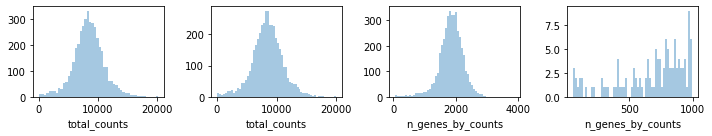

In [13]:
fig, axs = plt.subplots(1, 4, figsize = (10, 2))
sns.distplot(st_adata.obs["total_counts"], kde = False, ax = axs[0])
sns.distplot(st_adata.obs["total_counts"][st_adata.obs["total_counts"] < 20000], kde = False, bins = 60, ax = axs[1])
sns.distplot(st_adata.obs["n_genes_by_counts"], kde = False, bins = 60, ax = axs[2])
sns.distplot(st_adata.obs["n_genes_by_counts"][st_adata.obs["n_genes_by_counts"] < 1000], kde = False, bins = 60, ax = axs[3])
plt.tight_layout()
plt.show()

... storing 'feature_types' as categorical
... storing 'genome' as categorical


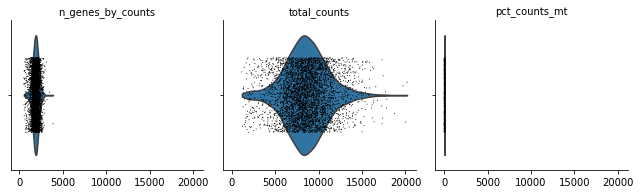

AnnData object with n_obs × n_vars = 4206 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [14]:
sc.pp.filter_cells(st_adata, min_counts = 500)
sc.pp.filter_cells(st_adata, min_genes = 500)
sc.pl.violin(st_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter = 0.25, multi_panel = True)
st_adata

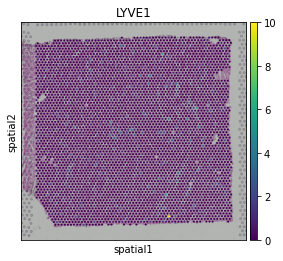

In [15]:
sc.pl.spatial(st_adata, img_key = "hires", color = ["LYVE1"])

## Learn cell-type specific gene expression from scRNA-seq data

Filter genes to be the same on the spatial data


In [16]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

Setup the AnnData object

In [17]:
scvi.data.setup_anndata(sc_adata, layer = "counts", labels_key = "cell_states")

INFO     No batch_key inputted, assuming all cells are same batch               
INFO     Using labels from adata.obs["cell_states"]                             
INFO     Using data from adata.layers["counts"]                                 
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 35928 cells, 7000    
         vars, 1 batches, 53 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


Train the _scRNA-Seq_ model

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 83/400:  20%|██        | 82/400 [02:23<09:15,  1.75s/it, loss=2.25e+03, v_num=1]


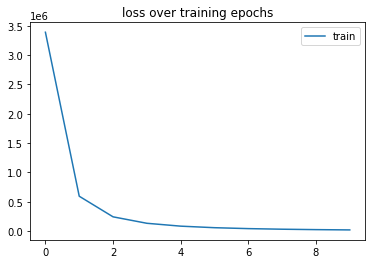

In [18]:
train = True
if train:
  sc_model = RNAStereoscope(sc_adata)
  sc_model.train(max_epochs = 400)
  plt.plot(sc_model.history["elbo_train"][:10], label = "train")
  plt.title("loss over training epochs")
  plt.legend()
  plt.show()
  sc_model.save("scmodel", overwrite=True)
else:
  sc_model = RNAStereoscope.load("scmodel", sc_adata)
  print("Loaded RNA model from file!")

## Infer proportion for spatial data

In [19]:
st_adata.layers["counts"] = st_adata.X.copy()
scvi.data.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch               
INFO     No label_key inputted, assuming all cells have same label              
INFO     Using data from adata.layers["counts"]                                 
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 4206 cells, 7000     
         vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra     
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


Train _Visium_ model

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5518/20000:  28%|██▊       | 5517/20000 [20:53<54:49,  4.40it/s, loss=1.08e+07, v_num=1]


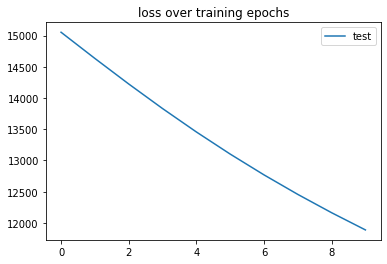

In [21]:
train=True
if train: 
  spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
  spatial_model.train(max_epochs = 20000)
  plt.plot(spatial_model.history["elbo_train"][:10], label = "test")
  plt.title("loss over training epochs")
  plt.legend()
  plt.show()
  spatial_model.save("stmodel", overwrite = True)
else:
  spatial_model = SpatialStereoscope.load("stmodel", st_adata)
  print("Loaded Spatial model from file!")

## Deconvolution results 

In [22]:
st_adata.obsm["deconvolution"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["deconvolution"].columns:
    st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

### Visualise populations

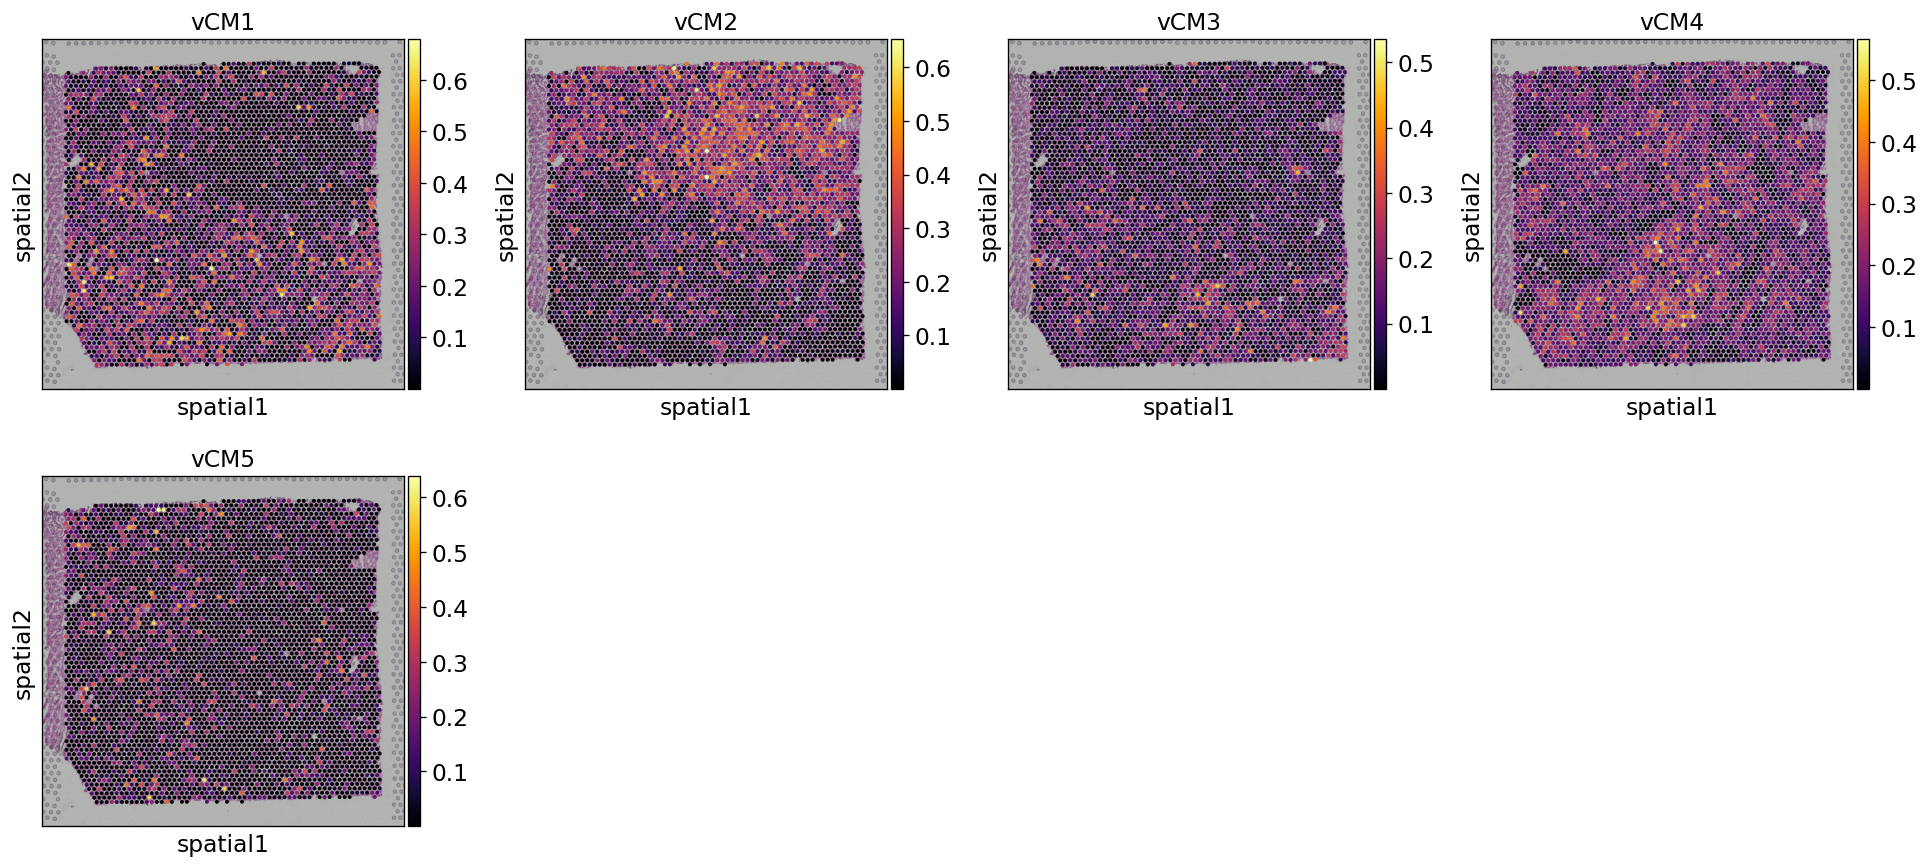

In [39]:
# low dpi for uploading to github
sc.settings.set_figure_params(dpi = 60, color_map = 'RdPu', dpi_save = 200, vector_friendly = True, format = 'svg')
sc.pl.spatial(st_adata, img_key = "hires", color = ['vCM1','vCM2','vCM3','vCM4', 'vCM5'], size = 1.2, color_map = 'inferno')

In [ ]:
sc.pl.spatial(st_adata, img_key = "hires", color = ['EC5_art','EC1_cap','EC2_cap','EC3_cap', 'EC6_ven', 'EC4_immune', 'EC8_ln', 'Meso'], 
              size = 1.2, color_map = 'inferno')

In [ ]:
sc.pl.spatial(st_adata, img_key = "hires", color = ['PC1_vent', 'PC3_str','SMC1_basic', 'SMC2_art'], size = 1.2, 
              color_map = 'inferno', save = '_PC-SMC_LV-public_scVI-Stereoscope_210106.png')

In [ ]:
sc.pl.spatial(st_adata, img_key = "lowres", color = ['FB1', 'FB2', 'FB3','FB4', 'FB5'], size = 1.2, 
              color_map = 'inferno', save = '_FB_LV-public_scVI-Stereoscope_210106.png')

In [ ]:
sc.pl.spatial(st_adata, img_key = "hires", color = ['B_cells', 'CD4+T_cytox', 'CD4+T_tem', 'CD8+T_cytox', 'CD8+T_tem', 'NK', 'NKT'], size = 1, 
              color_map = 'inferno', save = '_Lymphoid_LV-public_scVI-Stereoscope_210106.png')

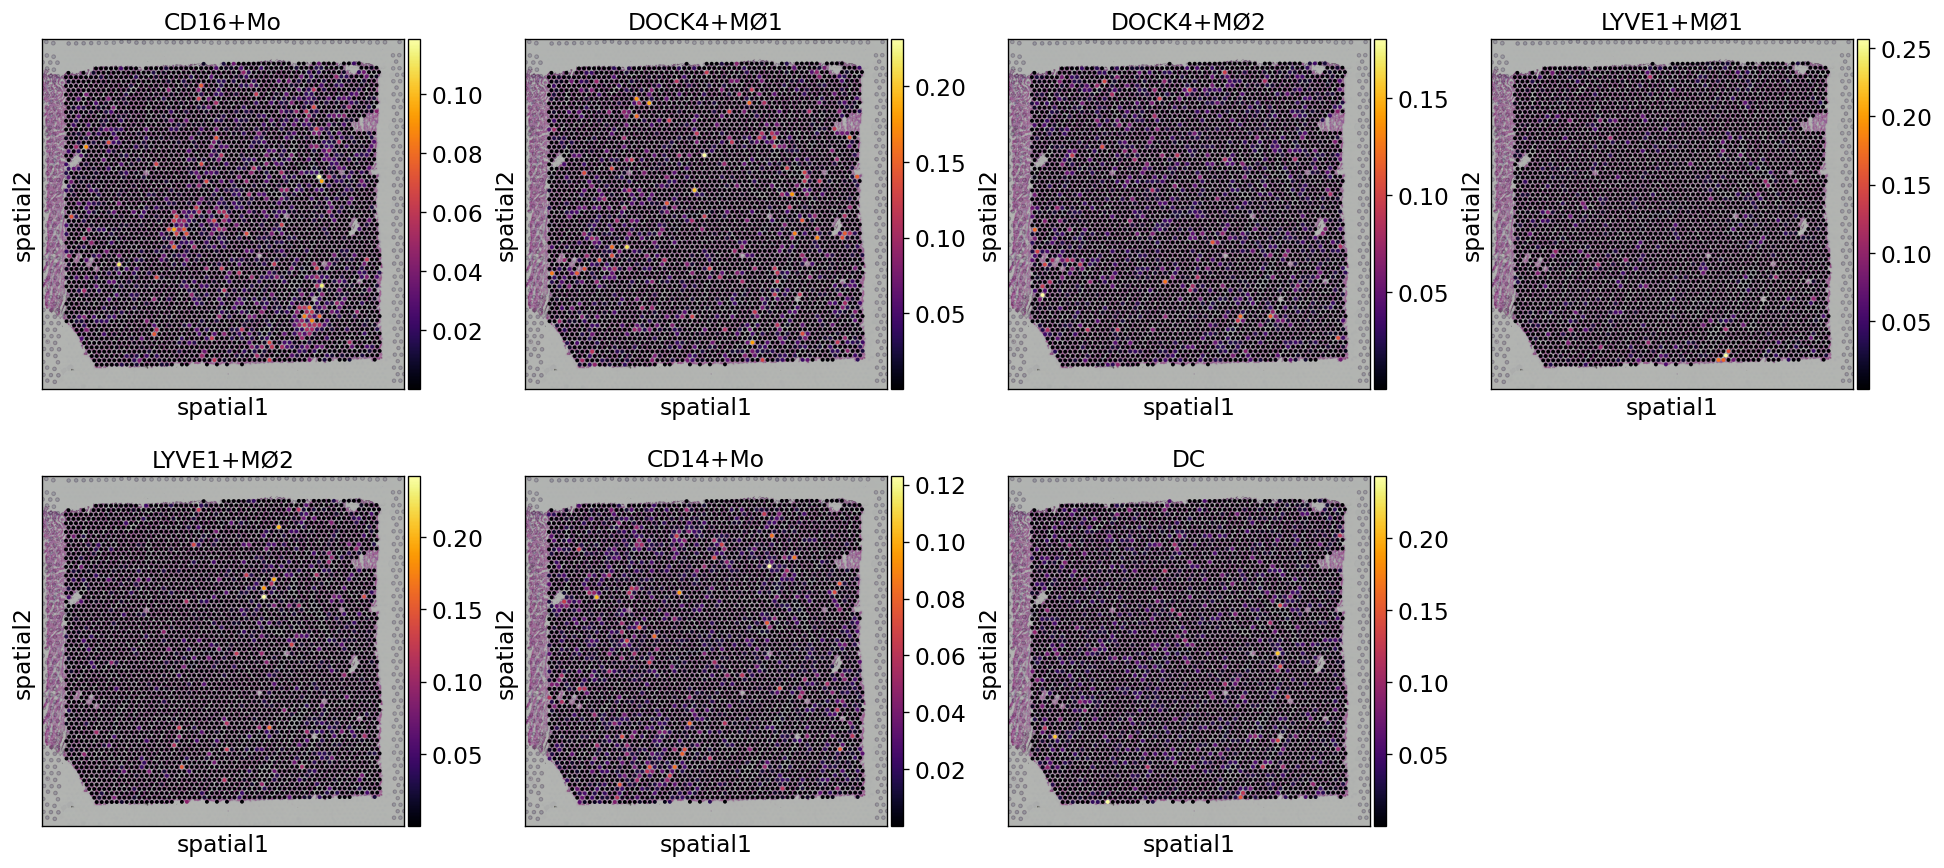

In [40]:
sc.pl.spatial(st_adata, img_key = "hires", color = ['CD16+Mo', 'DOCK4+MØ1', 'DOCK4+MØ2', 'LYVE1+MØ1', 'LYVE1+MØ2', 'CD14+Mo', 'DC'], size = 1.2, 
              color_map = 'inferno', save = '_Myeloid_LV-public_scVI-Stereoscope_210106.png')